In [1]:
import timm
import torch
from pycocotools.coco import COCO
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from pathlib import Path
import torchvision.transforms as transforms
from typing import List, Any
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
import albumentations as A
from albumentations.pytorch import ToTensorV2


In [2]:
def getImgIds_strict(self, imgIds=[], catIds=[]):
    '''
    Get img ids that satisfy given filter conditions.
    :param imgIds (int array) : get imgs for given ids
    :param catIds (int array) : get imgs with all given cats
    :return: ids (int array)  : integer array of img ids
    '''
    # imgIds = imgIds if _isArrayLike(imgIds) else [imgIds]
    # catIds = catIds if _isArrayLike(catIds) else [catIds]

    ids = []
    self.imgToCats = defaultdict(list)
    for img in self.imgToAnns.keys():
        for box in self.imgToAnns[img]:
            self.imgToCats[img].append(box['category_id'])
    for i, img in enumerate(self.imgToAnns.keys()):
        save = True
        for id in imgIds:
            if id not in self.imgToCats[img]:
                save = False
                break
        if save:
            ids.append({img: self.imgToCats[img]})

    return list(ids)


In [4]:
val_annotations: str = "/datagrid/public_datasets/COCO/annotations/instances_val2017.json"
train_annotations: str = "/datagrid/public_datasets/COCO/annotations/instances_train2017.json"
COCO.getImgIds_strict = getImgIds_strict
coco = COCO(train_annotations)


loading annotations into memory...
Done (t=16.86s)
creating index...
index created!


In [82]:
from collections import defaultdict
a = defaultdict(list)
coco.dataset["annotations"]
foo = coco.getImgIds_strict(imgIds=[2, 3, 58, 67, 47])
susp = foo[0]
id_err = list(susp.keys())[0]
err_labels = coco.loadAnns(coco.getAnnIds(id_err))
print(err_labels)


[{200365: [58, 58, 58, 58, 67, 2, 3, 3, 47]}, {375769: [67, 2, 3, 1, 3, 28, 67, 67, 47, 58, 2, 28, 62, 1, 1, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62]}]


In [96]:
transform = A.Compose([
    A.Resize(height=224, width=224),

])


[{'segmentation': [[247.71, 354.7, 253.49, 346.99, 276.63, 337.35, 312.29, 333.49, 364.34, 331.57, 354.7, 327.71, 369.16, 325.78, 376.87, 333.49, 383.61, 330.6, 379.76, 321.93, 365.3, 320.0, 356.63, 317.11, 266.02, 331.57, 260.24, 334.46, 260.24, 337.35, 242.89, 338.31, 234.22, 338.31, 234.22, 348.92, 239.04, 353.73, 248.67, 355.66, 252.53, 353.73]], 'area': 1545.4213000000007, 'iscrowd': 0, 'image_id': 200365, 'bbox': [234.22, 317.11, 149.39, 38.55], 'category_id': 58, 'id': 509}, {'segmentation': [[274.58, 405.68, 298.32, 405.68, 302.45, 402.58, 333.42, 404.65, 356.13, 397.42, 386.06, 386.06, 398.45, 367.48, 399.48, 356.13, 392.26, 347.87, 382.97, 350.97, 339.61, 357.16, 283.87, 365.42, 269.42, 367.48, 243.61, 362.32, 239.48, 368.52, 241.55, 374.71, 253.94, 381.94, 267.35, 385.03, 271.48, 394.32, 271.48, 399.48, 272.52, 400.52, 281.81, 404.65]], 'area': 5607.661349999996, 'iscrowd': 0, 'image_id': 200365, 'bbox': [239.48, 347.87, 160.0, 57.81], 'category_id': 58, 'id': 603}, {'segmen

In [3]:
# timm.list_models('*efficientnetv2*')
train_root: str = "/datagrid/public_datasets/COCO/train2017"
val_root: str = "/datagrid/public_datasets/COCO/val2017"
train_annotations: str = "/datagrid/public_datasets/COCO/annotations/instances_train2017.json"
val_annotations: str = "/datagrid/public_datasets/COCO/annotations/instances_val2017.json"


def xywh_to_xyxy(box):
    x, y, w, h = box
    return [x, y, x+w, y+h]


class COCODataset(Dataset):
    def __init__(self, root, annFile):
        super().__init__()
        self.root = root
        self.coco = COCO(annFile)
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                                 0.229, 0.224, 0.225])
        ])
        self.Atransforms = A.Compose([
            # A.Resize(width=224, height=224),
            # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels'], min_visibility=0.4, min_area=5))
        self.category_names = {}
        for cat in self.coco.loadCats(self.coco.getCatIds()):
            self.category_names[cat['id']] = cat['name']

    def _load_image(self, id: int) -> Image.Image:
        path = self.coco.loadImgs(id)[0]["file_name"]
        return Image.open(Path(self.root)/path).convert("RGB")

    def _load_target(self, id: int) -> List[Any]:
        targets = self.coco.loadAnns(self.coco.getAnnIds(id))
        boxes = []
        labels = []
        for box in targets:
            # if box["bbox"][2] == 0 or box["bbox"][3] == 0:
            #     #TODO change to log warn
            #     print(f"Warn! bbox with id:{box['id']} is invalid")
            #     continue
            boxes.append(xywh_to_xyxy(box["bbox"]))
            labels.append(box["category_id"])

        return {"boxes": torch.tensor(boxes) if len(boxes) != 0 else torch.empty((0, 4)),
                "labels": torch.tensor(labels).type(torch.int64)}

    def __getitem__(self, index):
        id = self.ids[index]
        img = self._load_image(id)
        target = self._load_target(id)
        transformed = self.Atransforms(image=np.array(
            img), bboxes=target["boxes"], class_labels=target["labels"])
        img = transformed['image']
        target["boxes"] = torch.tensor(transformed["bboxes"])
        target["labels"] = torch.tensor(transformed["class_labels"])

        # transformed = self.transforms(img)
        return img, target

    def __len__(self) -> int:
        return len(self.ids)




loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


/tmp/ipykernel_19691/3053920445.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target["boxes"] = torch.tensor(transformed["bboxes"])
/tmp/ipykernel_19691/3053920445.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target["labels"] = torch.tensor(transformed["class_labels"])


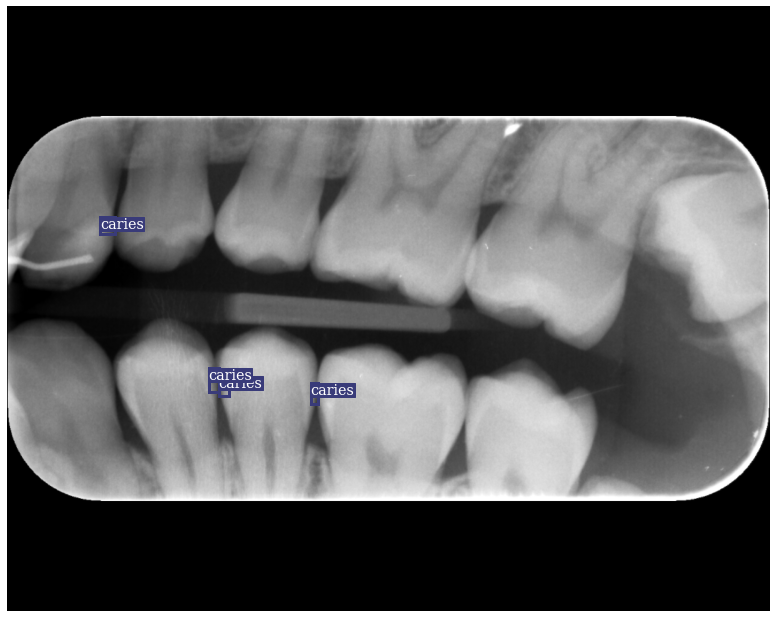

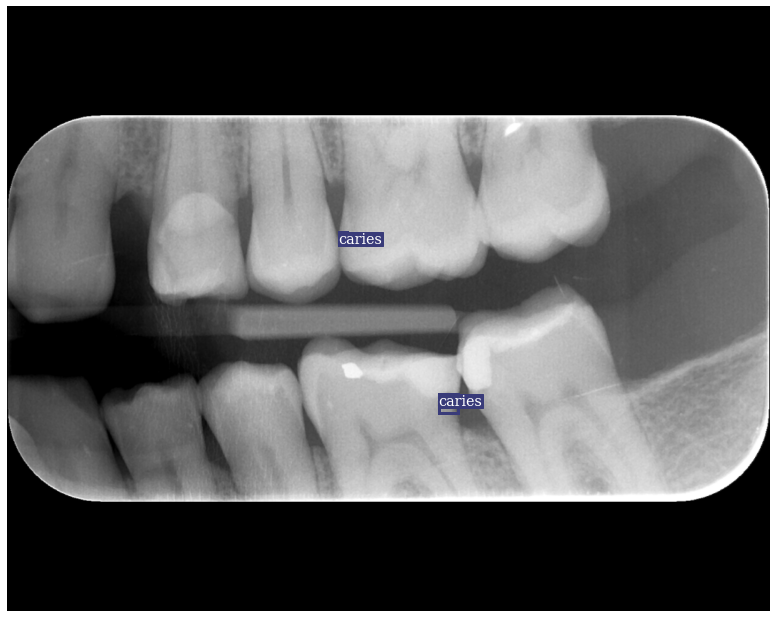

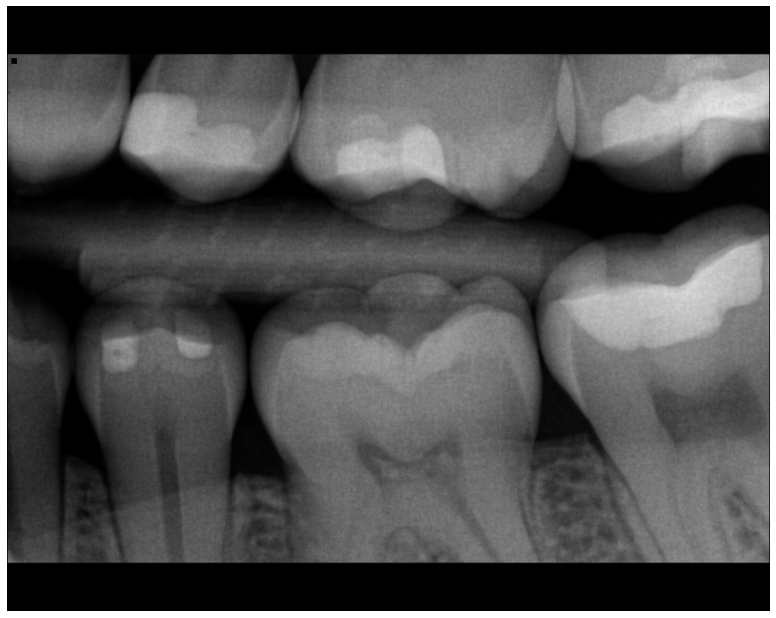

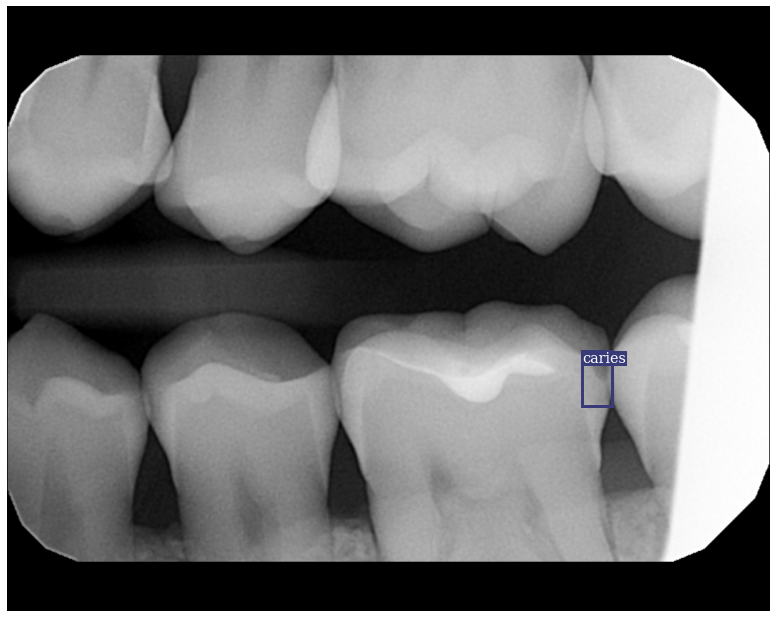

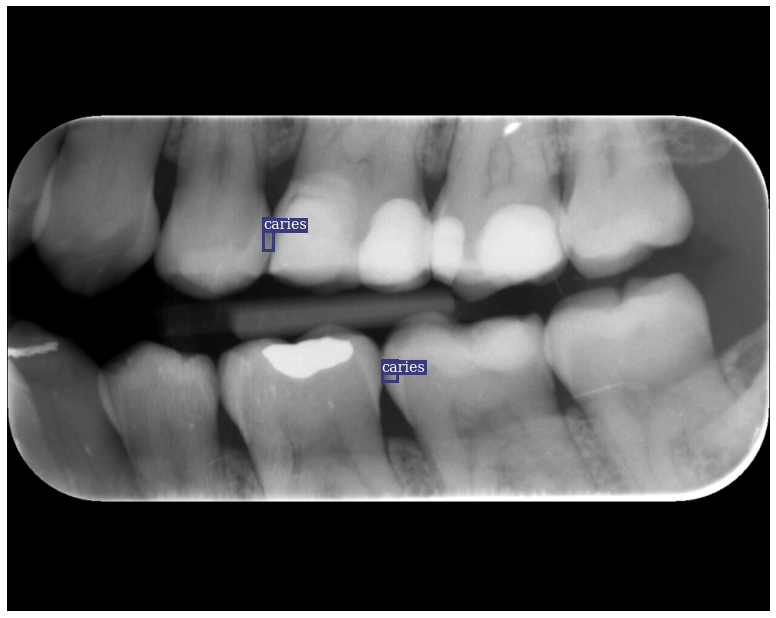

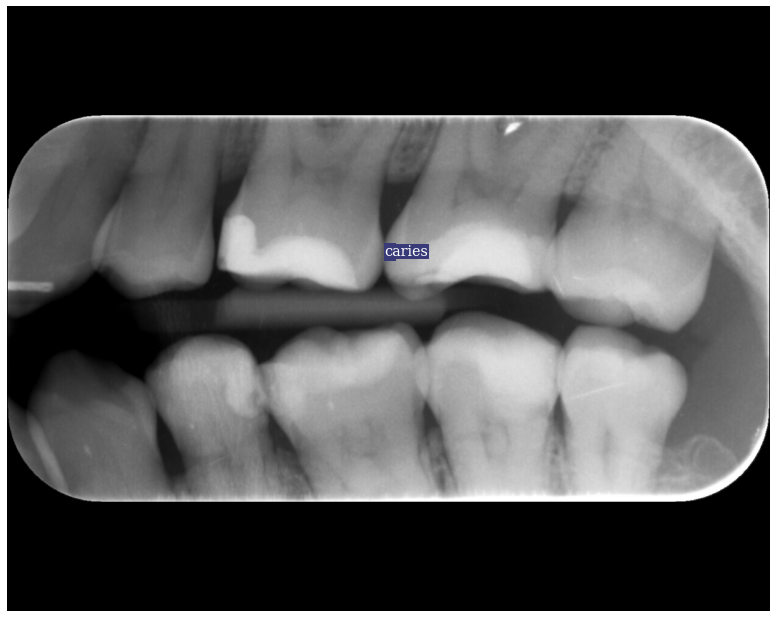

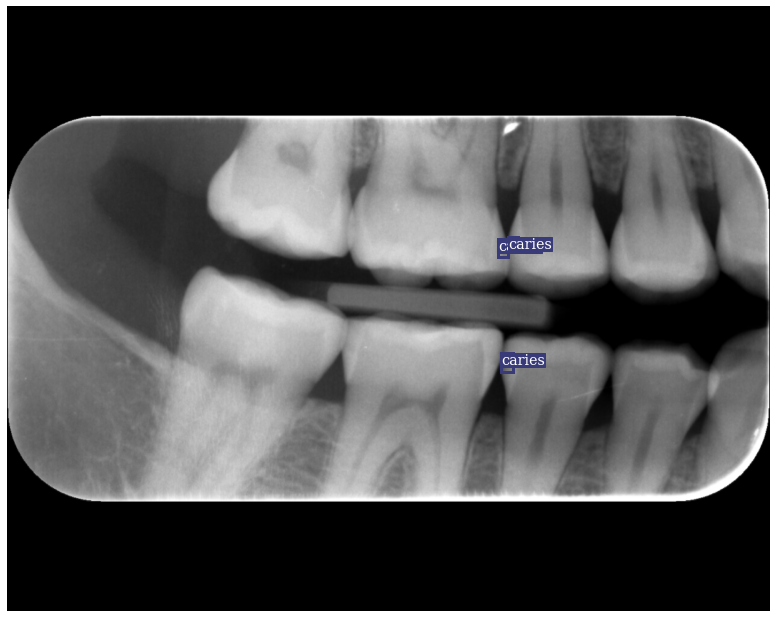

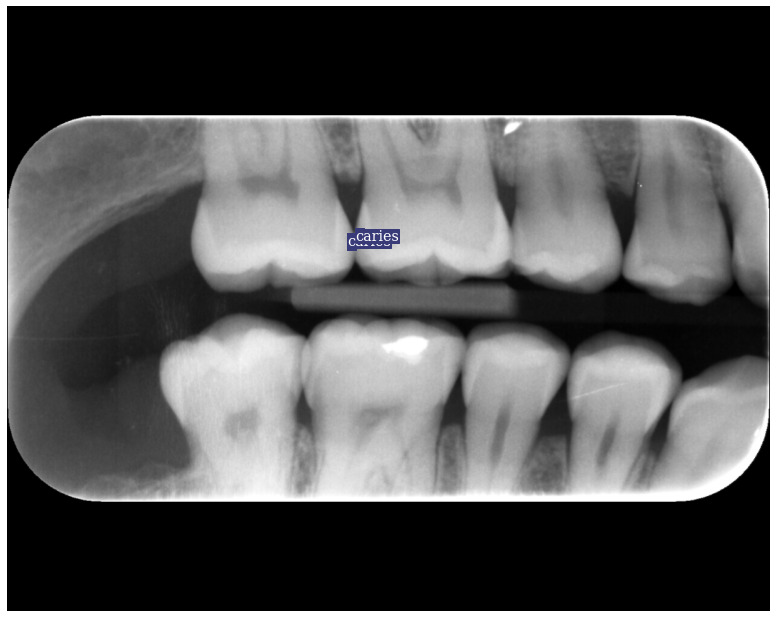

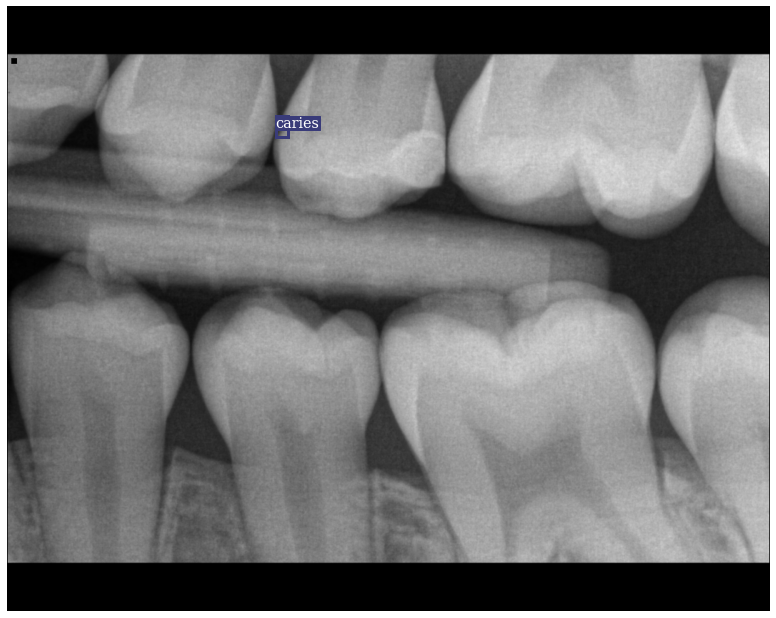

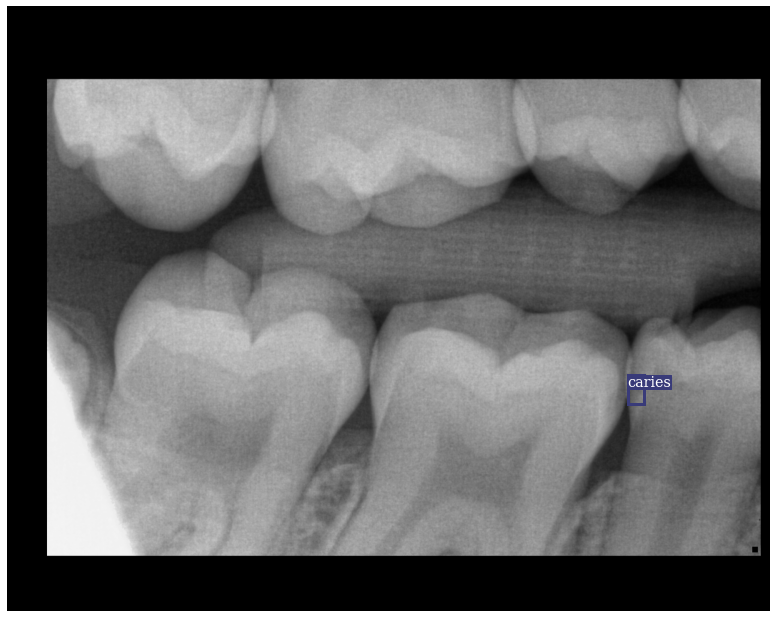

In [6]:
%matplotlib inline

dataset_images_path = Path(
    "/home.stud/kuntluka/dataset/carries_dataset/images")
dataset_annotations_path = Path(
    "/home.stud/kuntluka/dataset/carries_dataset/annotations.json")
dataset = COCODataset(dataset_images_path, dataset_annotations_path)
for i in range(10):
    x, y = dataset[i]
    plt_img_bb(x,y)

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline


def plt_img_bb(img, targets):
    cmap = plt.get_cmap("tab20b")
    # detection_labels = torch.tensor([x["labels"] for x in targets])
    # detection_rects = torch.tensor([x["boxes"] for x in targets])
    detection_labels = targets['labels']
    detection_rects = targets['boxes']
    # detection_labels = torch.tensor(targets['labels'])
    # detection_rects = torch.tensor(targets['boxes'])
    unique_labels = detection_labels.unique()
    n_cls_pred = len(unique_labels)
    colors = [cmap(i) for i in np.linspace(0, 1, n_cls_pred)]

    dpi = 80
    _, width, height = img.shape
    figsize = width / float(dpi), height / float(dpi)

    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.imshow(transforms.ToPILImage()(img))
    for box, label in zip(detection_rects, detection_labels):
        x1, y1, x2, y2 = box
        label = int(label)
        color = colors[int(np.where(unique_labels == label)[0])]
        bbox = patches.Rectangle(
            (x1, y1), x2 - x1, y2 - y1, linewidth=3, edgecolor=color, facecolor="none")
        ax.add_patch(bbox)
        plt.text(x1, y1, s=dataset.category_names[int(label)], color="white", fontsize="x-large",
                 verticalalignment="top", bbox={"color": color, "pad": 0}, fontfamily="serif")
    plt.axis("off")
    plt.savefig("tesp.jpg", dpi=dpi, transparent=True)
    plt.show()


In [9]:
# class COCODataLoader(DataLoader):
#     def __init__(self):

def collate(batch):
    return tuple(zip(*batch))


loader = DataLoader(dataset, batch_size=4, collate_fn=collate, num_workers=8)
# loader = DataLoader(dataset, batch_size=4, num_workers=0)


In [7]:
def get_dataset_mean_std(dataloader : DataLoader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0

    for data, _ in dataloader:
        data = torch.stack(data)
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1
    
    mean = channels_sum / num_batches
    std = (channels_squared_sum/num_batches - mean**2)**0.5
    return mean, std

In [11]:
mean, std = get_dataset_mean_std(loader)
print(mean, std)
print(next(iter(loader)))

/tmp/ipykernel_19691/3053920445.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target["boxes"] = torch.tensor(transformed["bboxes"])
/tmp/ipykernel_19691/3053920445.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target["labels"] = torch.tensor(transformed["class_labels"])


RuntimeError: Can only calculate the mean of floating types. Got Long instead.

In [32]:
import wandb
wandb.init()
foo = next(iter(loader))
print(foo)
imgs = foo[0]
labels = foo[1]
imgs_to_log = []
for img, label in zip(imgs, labels):
    positions = []
    positions2 = []
    for box in label:
        box_pos2 = {
            "position": {
                "minX": box["bbox"][0] + 10,
                "minY": box["bbox"][1] + 10,
                "maxX": box["bbox"][2] + box["bbox"][0] - 10,
                "maxY": box["bbox"][3] + box["bbox"][1] - 10
            },
            "class_id": box["category_id"],
            "domain": "pixel"
        }
        box_pos = {
            "position": {
                "minX": box["bbox"][0],
                "minY": box["bbox"][1],
                "maxX": box["bbox"][2] + box["bbox"][0],
                "maxY": box["bbox"][3] + box["bbox"][1]
            },
            "class_id": box["category_id"],
            "domain": "pixel"
        }
        positions.append(box_pos)
        positions2.append(box_pos2)
    boxes = {
        "predictions": {
            "box_data": positions
        },
        "ground_truth": {
            "box_data": positions2
        }
    }
    wandb_img = wandb.Image(img, boxes=boxes)
    imgs_to_log.append(wandb_img)
wandb.log({"test_img": imgs_to_log})

# for box in labels[]
# print(img)


((<PIL.Image.Image image mode=RGB size=640x480 at 0x7FDD6531BF70>, <PIL.Image.Image image mode=RGB size=640x426 at 0x7FDD6531BF40>, <PIL.Image.Image image mode=RGB size=640x428 at 0x7FDD6531BFA0>, <PIL.Image.Image image mode=RGB size=640x425 at 0x7FDD6531BFD0>), ([{'segmentation': [[500.49, 473.53, 599.73, 419.6, 612.67, 375.37, 608.36, 354.88, 528.54, 269.66, 457.35, 201.71, 420.67, 187.69, 389.39, 192.0, 19.42, 360.27, 1.08, 389.39, 2.16, 427.15, 20.49, 473.53]], 'area': 120057.13925, 'iscrowd': 0, 'image_id': 9, 'bbox': [1.08, 187.69, 611.59, 285.84], 'category_id': 51, 'id': 1038967}, {'segmentation': [[357.03, 69.03, 311.73, 15.1, 550.11, 4.31, 631.01, 62.56, 629.93, 88.45, 595.42, 185.53, 513.44, 230.83, 488.63, 232.99, 437.93, 190.92, 429.3, 189.84, 434.7, 148.85, 410.97, 121.89, 359.19, 74.43, 358.11, 65.8]], 'area': 44434.751099999994, 'iscrowd': 0, 'image_id': 9, 'bbox': [311.73, 4.31, 319.28, 228.68], 'category_id': 51, 'id': 1039564}, {'segmentation': [[249.6, 348.99, 267.6

In [17]:
print(labels[0])


{'segmentation': [[4.78, 22.92, 75.45, 39.16, 148.03, 46.8, 185.28, 28.65, 212.02, 20.06, 247.36, 29.61, 271.24, 40.11, 285.56, 44.89, 298.93, 64.94, 331.4, 77.36, 369.61, 107.92, 421.18, 161.4, 442.19, 226.35, 440.28, 255.0, 416.4, 235.9, 421.18, 274.1, 427.87, 320.9, 432.64, 356.24, 421.18, 380.11, 392.53, 393.48, 377.25, 388.71, 378.2, 363.88, 353.37, 336.18, 335.22, 308.48, 338.09, 269.33, 318.99, 245.45, 284.61, 214.89, 260.73, 214.89, 253.09, 230.17, 267.42, 251.18, 288.43, 273.15, 292.25, 273.15, 295.11, 308.48, 293.2, 334.27, 288.43, 362.92, 284.61, 382.02, 256.91, 369.61, 263.6, 346.69, 271.24, 312.3, 272.19, 295.11, 231.12, 258.82, 202.47, 250.22, 179.55, 298.93, 173.82, 321.85, 167.13, 352.42, 171.91, 369.61, 177.64, 382.98, 160.45, 398.26, 142.3, 399.21, 148.03, 382.98, 142.3, 359.1, 152.81, 307.53, 157.58, 273.15, 173.82, 216.8, 116.52, 215.84, 63.99, 223.48, 13.37, 210.11, 0.96, 21.97]], 'area': 92920.15370000002, 'iscrowd': 0, 'image_id': 34, 'bbox': [0.96, 20.06, 441.23

In [5]:
from pl_bolts.models.detection.faster_rcnn import FasterRCNN
from pytorch_lightning import Trainer

model = FasterRCNN()
trainer = Trainer(gpus=1)
trainer.fit(model, train_dataloaders=loader)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home.stud/kuntluka/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:118: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name  | Type       | Params
-------------------------------------
0 | model | FasterRCNN | 41.8 M
-------------------------------------
41.5 M    Trainable params
222 K     Non-trainable params
41.8 M    Total params
167.021   Total estimated model params size (MB)
/home.stud/kuntluka/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:110: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` 

Training: 0it [00:00, ?it/s]

AttributeError: 'list' object has no attribute 'items'